# Intent recognition

### Dataset used:
ecommerce-intent.csv

### Steps

- Preprocess and clean the dataset
- tokenization, stopword removal, and lemmatization using NLTK
- Create Word2Vec embeddings to capture semantic meaning in the text
- Create document vectors by averaging Word2Vec embeddings for each word in a document
- Train randomforestclassifier on these document vectors to predict intents
- Incorporate tfidf features to capture important words and improve the model's performance
- Save the trained model

In [17]:
import nltk
import joblib
import re
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/ram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# import pandas as pd

# df = pd.read_csv(
#     "hf://datasets/ikshana-zehntech/ecommerce_intent_recognition/ecommerce_intent.csv")

In [3]:
# df.to_csv('ecommerce_intent.csv', index=False)

In [3]:
df = pd.read_csv('ecommerce_intent.csv')
df.head()

,context,response
0,question about cancelling order 2B4FZM0C,"intent: cancel_order, variable name: order_num..."
1,i have a question about cancelling oorder 23W8...,"intent: cancel_order, variable name: order_num..."
2,i need help cancelling puchase B7UX7Q76,"intent: cancel_order, variable name: order_num..."
3,I need to cancel purchase GTY5LI52,"intent: cancel_order, variable name: order_num..."
4,"I cannot afford this order, cancel purchase 2L...","intent: cancel_order, variable name: order_num..."


In [5]:
df.shape

(27869, 2)

In [7]:
df.columns

Index(['context', ' response', 'cleaned_text'], dtype='object')

In [8]:
def clean_intent_recognition_data(df):
    def clean_context(context):
        # Remove order number or codes
        cleaned_text = re.sub(r'\b[A-Z0-9]{6, }\b', '', context)
        # Remove any remaining special charecters and extra whitespace
        cleaned_text = re.sub(r'[^a-zA-Z\s]', '', cleaned_text)
        return cleaned_text.strip()

    def extract_intent(response):
        intent_match = re.search(r'intent:\s*(\w+)', response)
        return intent_match.group(1) if intent_match else None

    # Clean the context column
    df['cleaned_text'] = df['content'].apply(clean_context)

    # Extract intent from the response column
    df['intent'] = df[' response'].apply(clean_context)

    # Return only the cleaned text and intent column
    return df[['cleaned_text', 'intent']]


cleaned_df = clean_intent_recognition_data(df)

                                 cleaned_text        intent
0             question about cancelling order  cancel_order
1   i have a question about cancelling oorder  cancel_order
2              i need help cancelling puchase  cancel_order
3                   I need to cancel purchase  cancel_order
4  I cannot afford this order cancel purchase  cancel_order


In [11]:
cleaned_df.sample(10)

,cleaned_text,intent
25917,I am trying to find information about a forgot...,recover_password
2069,modifying details on pro account,edit_account
21403,do ya deliver to India,delivery_options
24078,where can i check the bloody eta of order,track_order
19044,i have problems with opening a freemium account,create_account
11168,help me to see what payment payment modalities...,check_payment_methods
7452,I need assistance to talk to an operator,contact_human_agent
6850,where to make a customer complaint against ur ...,complaint
11937,where to check what payment payment modalities...,check_payment_methods
12488,I want assistance to notify of problems with a...,registration_problems


In [12]:
cleaned_df.to_csv('ecommerce_intent_cleaned.csv', index=False)

### Load and preprocess the data

In [13]:
def load_data(file_path):
    return pd.read_csv(file_path)


def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.isalnum()
              and token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens


file_path = 'ecommerce_intent_cleaned.csv'
df = load_data(file_path)
df['processed_text'] = df['cleaned_text'].apply(preprocess_text)

In [14]:
df.sample(10)

,cleaned_text,intent,processed_text
25297,how to restore my profile access key,recover_password,"[restore, profile, access, key]"
26785,I have entered a wrong fucking delivery addres...,change_shipping_address,"[entered, wrong, fucking, delivery, address, c..."
19104,where can I create a freemium account,create_account,"[create, freemium, account]"
12249,Im trying to notify of errors with signup,registration_problems,"[im, trying, notify, error, signup]"
7060,i do not know how i can talk to a human agent,contact_human_agent,"[know, talk, human, agent]"
3879,help using the Platinum account,switch_account,"[help, using, platinum, account]"
17664,i do not know how to obtain rebates of money,get_refund,"[know, obtain, rebate, money]"
4653,ser the bill,check_invoice,"[ser, bill]"
17763,need help requesting a compensation of money,get_refund,"[need, help, requesting, compensation, money]"
1999,edit premium accont,edit_account,"[edit, premium, accont]"


### Create Word2Vec embeddings:

In [15]:
def create_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    model = Word2Vec(sentences=sentences, vector_size=vector_size,
                     window=window, min_count=min_count, workers=workers)
    return model


word2vec_model = create_word2vec_model(df['processed_text'])

In [18]:
def get_document_vector(tokens, model, vector_size=100):
    vec = np.zeros(vector_size)
    count = 0
    for word in tokens:
        try:
            vec += model.wv[word]
            count += 1
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec


df['doc_vector'] = df['processed_text'].apply(
    lambda x: get_document_vector(x, word2vec_model))

In [19]:
df.head()

,cleaned_text,intent,processed_text,doc_vector
0,question about cancelling order,cancel_order,"[question, cancelling, order]","[-0.03374878317117691, -0.48042162756125134, -..."
1,i have a question about cancelling oorder,cancel_order,"[question, cancelling, oorder]","[-0.10244156622017424, -0.27942289349933463, -..."
2,i need help cancelling puchase,cancel_order,"[need, help, cancelling, puchase]","[-0.09994642937090248, -0.26999330148100853, -..."
3,I need to cancel purchase,cancel_order,"[need, cancel, purchase]","[-0.07953296601772308, -0.5398356715838114, -0..."
4,I cannot afford this order cancel purchase,cancel_order,"[afford, order, cancel, purchase]","[0.005723701789975166, -0.6093969494104385, 0...."


### Prepare data for training:

In [20]:
X = np.array(df['doc_vector'].tolist())
le = LabelEncoder()
y = le.fit_transform(df['intent'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

### Train a Random Forest Classifier:

In [21]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Evaluate the model

                          precision    recall  f1-score   support

            cancel_order       0.98      0.98      0.98       187
            change_order       0.97      1.00      0.98       406
 change_shipping_address       0.98      0.99      0.99       191
  check_cancellation_fee       1.00      1.00      1.00       198
           check_invoice       0.94      0.94      0.94       198
   check_payment_methods       1.00      0.99      1.00       200
     check_refund_policy       0.99      1.00      1.00       200
               complaint       1.00      1.00      1.00       187
contact_customer_service       1.00      0.99      0.99       204
     contact_human_agent       0.99      1.00      1.00       205
          create_account       0.93      0.93      0.93       193
          delete_account       0.89      0.90      0.90       207
        delivery_options       1.00      1.00      1.00       210
         delivery_period       1.00      1.00      1.00       213
         

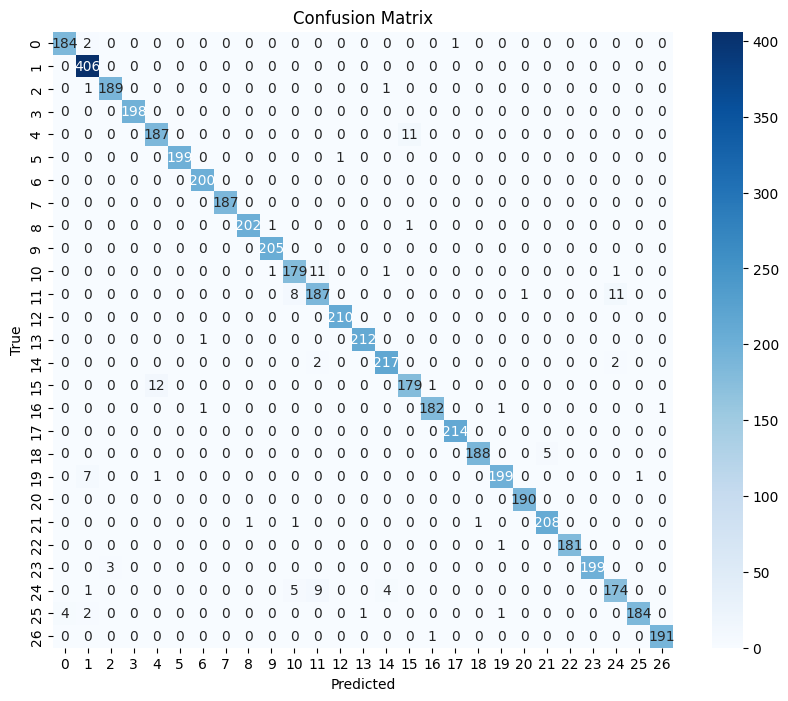

In [22]:
y_pred = rf_classifier.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Create a function to predict intent for new texts:

In [23]:
def predict_intent(text, word2vec_model, rf_classifier, le):
    processed_text = preprocess_text(text)
    doc_vector = get_document_vector(processed_text, word2vec_model)
    intent_id = rf_classifier.predict([doc_vector])[0]
    intent = le.inverse_transform([intent_id])[0]
    return intent


# Example usage
new_text = "I'm having trouble logging into my account. Can you help?"
predicted_intent = predict_intent(new_text, word2vec_model, rf_classifier, le)
print(f"Predicted intent: {predicted_intent}")

Predicted intent: registration_problems


### Improve the model with TF-IDF features:

In [25]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf_vectorizer.fit_transform(df['cleaned_text'])

X_combined = np.hstack((X, tfidf_features.toarray()))
X_train_combined, X_test_combined, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

rf_classifier_combined = RandomForestClassifier(
    n_estimators=150, random_state=42)
rf_classifier_combined.fit(X_train_combined, y_train)

y_pred_combined = rf_classifier_combined.predict(X_test_combined)
print(classification_report(y_test, y_pred_combined, target_names=le.classes_))

                          precision    recall  f1-score   support

            cancel_order       0.97      0.98      0.98       187
            change_order       0.97      1.00      0.98       406
 change_shipping_address       0.99      0.98      0.99       191
  check_cancellation_fee       1.00      1.00      1.00       198
           check_invoice       0.96      0.94      0.95       198
   check_payment_methods       1.00      0.99      0.99       200
     check_refund_policy       0.99      0.99      0.99       200
               complaint       1.00      1.00      1.00       187
contact_customer_service       1.00      0.99      1.00       204
     contact_human_agent       0.99      1.00      0.99       205
          create_account       0.96      0.94      0.95       193
          delete_account       0.93      0.94      0.93       207
        delivery_options       0.99      1.00      1.00       210
         delivery_period       0.99      1.00      1.00       213
         

### Save the trained models and vectorizers:

In [26]:
joblib.dump(word2vec_model, 'word2vec_model.joblib')
joblib.dump(rf_classifier, 'rf_classifier.joblib')
joblib.dump(le, 'label_encoder.joblib')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')
joblib.dump(rf_classifier_combined, 'rf_classifier_combined.joblib')

['rf_classifier_combined.joblib']

In [ ]:
# Django view or service
import joblib
from preprocess_module import preprocess_text, get_document_vector

word2vec_model = joblib.load('word2vec_model.joblib')
rf_classifier = joblib.load('rf_classifier.joblib')
le = joblib.load('label_encoder.joblib')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.joblib')
rf_classifier_combined = joblib.load('rf_classifier_combined.joblib')


def predict_intent_django(text):
    processed_text = preprocess_text(text)
    doc_vector = get_document_vector(processed_text, word2vec_model)
    tfidf_features = tfidf_vectorizer.transform([text]).toarray()
    combined_features = np.hstack((doc_vector.reshape(1, -1), tfidf_features))
    intent_id = rf_classifier_combined.predict(combined_features)[0]
    intent = le.inverse_transform([intent_id])[0]
    return intent

# Django view


def intent_recognition_view(request):
    if request.method == 'POST':
        text = request.POST.get('text')
        intent = predict_intent_django(text)
        return JsonResponse({'intent': intent})
    return render(request, 'intent_recognition.html')